In [54]:
import os
import pandas as pd
from futu import *
from matplotlib import pyplot as plt
import hashlib
import base64
import hmac
import json
import requests
from requests_toolbelt.multipart.encoder import MultipartEncoder
import time

In [2]:
quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111)

2024-10-23 14:17:34,110 | 33284 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=1, host=127.0.0.1, port=11111, user_id=31759416


In [3]:
target_code = ['SH.688385', 'SH.688318', 'SH.688041']

In [78]:
target_code = {'SH.688385': '复旦微电',
                'SH.688318': '财富趋势',
                'SH.688041': '海光信息'}
print((list(target_code.keys())))

['SH.688385', 'SH.688318', 'SH.688041']


In [ ]:
# ret, data, page_req_key = quote_ctx.request_history_kline('SH.688385', start='2022-09-11', end='2019-09-18', max_count=5, ktype=KLType.K_15M)  # 每页5个，请求第一页

In [5]:
class OrderBookTest(OrderBookHandlerBase):
    def on_recv_rsp(self, rsp_pb):
        ret_code, data = super(OrderBookTest,self).on_recv_rsp(rsp_pb)
        if ret_code != RET_OK:
            print("OrderBookTest: error, msg: %s" % data)
            return RET_ERROR, data
        print("OrderBookTest ", data) # OrderBookTest 自己的处理逻辑
        return RET_OK, data

In [6]:
quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111)
handler = OrderBookTest()
quote_ctx.set_handler(handler)  # 设置实时摆盘回调

2024-10-23 14:40:52,335 | 33284 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=2, host=127.0.0.1, port=11111, user_id=31759416


0

In [7]:
quote_ctx.subscribe(['SH.688385'], [SubType.K_15M])

(0, None)

In [10]:
quote_ctx.close()

2024-10-23 14:46:02,627 | 33284 | [open_context_base.py] on_disconnect:383: Disconnected: conn_id=2


In [11]:
class CurKlineTest(CurKlineHandlerBase):
    def on_recv_rsp(self, rsp_pb):
        ret_code, data = super(CurKlineTest,self).on_recv_rsp(rsp_pb)
        if ret_code != RET_OK:
            print("CurKlineTest: error, msg: %s" % data)
            return RET_ERROR, data
        print("CurKlineTest ", data) # CurKlineTest 自己的处理逻辑
        return RET_OK, data
quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111)
handler = CurKlineTest()
quote_ctx.set_handler(handler)  # 设置实时K线回调
ret, data = quote_ctx.subscribe(['SH.688385'], [SubType.K_1M])   # 订阅 K 线数据类型，OpenD 开始持续收到服务器的推送
if ret == RET_OK:
    print(data)
else:
    print('error:', data)
time.sleep(15)  # 设置脚本接收 OpenD 的推送持续时间为15秒
quote_ctx.close()   # 关闭当条连接，OpenD 会在1分钟后自动取消相应股票相应类型的订阅    

2024-10-23 14:47:37,324 | 33284 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=3, host=127.0.0.1, port=11111, user_id=31759416
None
CurKlineTest          code  name             time_key   open  close   high   low  volume  \
0  SH.688385  复旦微电  2024-10-23 14:48:00  46.02   46.0  46.04  46.0   86180   

    turnover k_type  last_close  
0  3964985.0   K_1M         0.0  
CurKlineTest          code  name             time_key   open  close   high   low  volume  \
0  SH.688385  复旦微电  2024-10-23 14:48:00  46.02  46.01  46.04  46.0   96062   

    turnover k_type  last_close  
0  4419549.0   K_1M         0.0  
CurKlineTest          code  name             time_key   open  close   high   low  volume  \
0  SH.688385  复旦微电  2024-10-23 14:48:00  46.02   46.0  46.04  46.0  100122   

    turnover k_type  last_close  
0  4606342.0   K_1M         0.0  
CurKlineTest          code  name             time_key   open  close   high   low  volume  \
0  SH.688385  复旦微电  2024-10-

In [15]:
import numpy as np
def calculate_kdj(high_prices, low_prices, close_prices, n=9, m1=3, m2=3):
    """
    计算KDJ指标

    参数:
    high_prices: 周期内最高价列表
    low_prices: 周期内最低价列表
    close_prices: 收盘价列表
    n: RSV的计算周期，默认9
    m1: K值的平滑周期，默认3
    m2: D值的平滑周期，默认3

    返回:
    k_list: K值列表
    d_list: D值列表
    j_list: J值列表
    """
    length = len(close_prices)
    k_list = []
    d_list = []
    j_list = []
    for i in range(length):
        if i < n - 1:
            # 在计算周期未满时，先添加None值
            k_list.append(None)
            d_list.append(None)
            j_list.append(None)
            continue
        high_max = np.max(high_prices[i - n + 1:i + 1])
        low_min = np.min(low_prices[i - n + 1:i + 1])
        rsv = ((close_prices[i] - low_min) / (high_max - low_min)) * 100
        if i == n - 1:
            k = rsv
            d = rsv
        else:
            k = ((m1 - 1) * k_list[i - 1] + rsv) / m1
            d = ((m2 - 1) * d_list[i - 1] + k) / m2
        j = 3 * k - 2 * d
        k_list.append(k)
        d_list.append(d)
        j_list.append(j)
    return k_list, d_list, j_list

In [70]:
quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111)
ret_sub, err_message = quote_ctx.subscribe(['SH.688385'], [SubType.K_15M], subscribe_push=False)
# 先订阅 K 线类型。订阅成功后 OpenD 将持续收到服务器的推送，False 代表暂时不需要推送给脚本
if ret_sub == RET_OK:  # 订阅成功
    ret, data = quote_ctx.get_cur_kline('SH.688385', 20, KLType.K_15M, AuType.QFQ) 
    if ret == RET_OK:
        high_list = data['high'].values.tolist()
        low_list = data['low'].values.tolist()
        close_list = data['close'].values.tolist()
        print(type(data))
        k_list, d_list, j_list = calculate_kdj(high_list, low_list, close_list, n=5, m1=3, m2=3)
        print("K值:", k_list)
        print("D值:", d_list)
        print("J值:", j_list)
    else:
        print('error:', data)
else:
    print('subscription failed', err_message)
quote_ctx.close()  # 关闭当条连接，OpenD 会在1分钟后自动取消相应股票相应类型的订阅

2024-10-24 17:25:02,599 | 33284 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=575, host=127.0.0.1, port=11111, user_id=31759416
<class 'pandas.core.frame.DataFrame'>
K值: [None, None, None, None, 26.470588235294084, 26.67483660130719, 24.72766884531585, 32.926554004985306, 37.266351318638876, 39.033423401615195, 43.93611446728994, 48.111604656197805, 36.46036801641233, 27.969915673945255, 29.269321072007646, 26.759257526266193, 25.085881829105222, 23.97029803099777, 29.980198687331903, 37.44711658520524]
D值: [None, None, None, None, 26.470588235294084, 26.538671023965122, 25.93500363108203, 28.265520422383123, 31.265797387801708, 33.85500605907287, 37.21537552847856, 40.847451904384975, 39.385090608394094, 35.58003229691115, 33.47646188860998, 31.23739376782872, 29.18688978825422, 27.448025869168735, 28.292083475223123, 31.343761178550494]
J值: [None, None, None, None, 26.47058823529408, 26.94716775599133, 22.312999273783497, 42.24862117018967, 49.26745918

In [71]:
res = pd.DataFrame({'k': k_list, 'j': j_list, 'd': d_list, 'price': close_list})

In [72]:
res

,k,j,d,price
0,NaN,NaN,NaN,46.23
1,NaN,NaN,NaN,46.49
2,NaN,NaN,NaN,46.05
3,NaN,NaN,NaN,46.16
4,26.470588,26.470588,26.470588,45.76
5,26.674837,26.947168,26.538671,45.71
6,24.727669,22.312999,25.935004,45.62
7,32.926554,42.248621,28.265520,46.05
8,37.266351,49.267459,31.265797,46.00
9,39.033423,49.390258,33.855006,45.95


In [73]:
res = res.dropna()

In [74]:
res['j_diff'] = res['j'].diff()
res['j_diff'] = res['j_diff'].apply(lambda x: 1 if x > 0 else 0)
res['close_diff'] = res['close'].diff()
res['close_diff'] = res['close_diff'].apply(lambda x: 1 if x > 0 else 0)

C:\Users\liang.dong\AppData\Local\Temp\ipykernel_33284\129548968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['kdj_signal'] = res['j'].diff()
C:\Users\liang.dong\AppData\Local\Temp\ipykernel_33284\129548968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['kdj_signal'] = res['kdj_signal'].apply(lambda x: 'BULL' if x > 0 else 'BEAR')


In [75]:
res

,k,j,d,price,kdj_signal
4,26.470588,26.470588,26.470588,45.76,BEAR
5,26.674837,26.947168,26.538671,45.71,BULL
6,24.727669,22.312999,25.935004,45.62,BEAR
7,32.926554,42.248621,28.265520,46.05,BULL
8,37.266351,49.267459,31.265797,46.00,BULL
9,39.033423,49.390258,33.855006,45.95,BULL
10,43.936114,57.377592,37.215376,46.12,BULL
11,48.111605,62.639910,40.847452,46.16,BULL
12,36.460368,30.610923,39.385091,45.80,BEAR
13,27.969916,12.749682,35.580032,45.65,BEAR


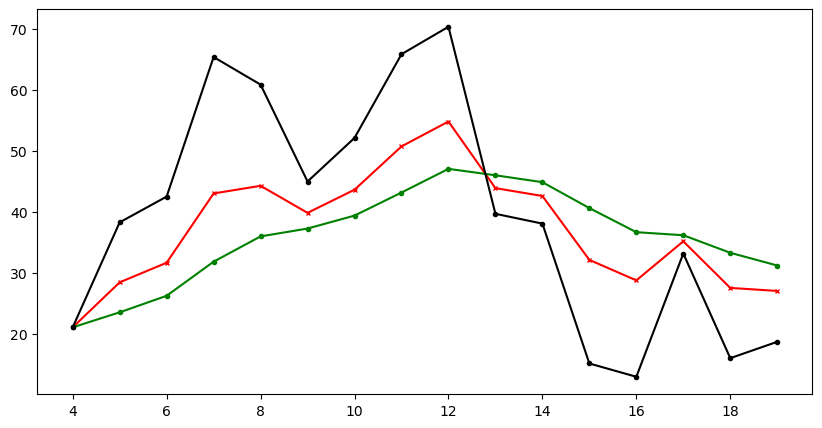

In [56]:
plt.figure(figsize=(10,5))
plt.plot(res['k'], marker='x', markersize=3, color='red')
plt.plot(res['d'], marker='o', markersize=3, color='green')
plt.plot(res['j'], marker='o', markersize=3, color='black')
# plt.plot(res['price'], marker='o', markersize=3, color='b')
plt.savefig('test.png')
plt.show()

In [51]:
def gen_sign(timestamp, secret):
    # 拼接timestamp和secret
    string_to_sign = '{}\n{}'.format(timestamp, secret)
    hmac_code = hmac.new(string_to_sign.encode("utf-8"), digestmod=hashlib.sha256).digest()
    # 对结果进行base64处理
    sign = base64.b64encode(hmac_code).decode('utf-8')
    return sign

## 上传图片

In [79]:
pic_url = "https://open.feishu.cn/open-apis/im/v1/images"
app_id = "cli_a238041d5339100d"
app_secret = "9MpYq5u3nC06pb4qNXX5QdErtK1fSOkE"

In [80]:
def get_tenant_access_token(app_id, app_secret):
    url = "https://open.feishu.cn/open-apis/auth/v3/tenant_access_token/internal"
    headers = {
        "Content-Type": "application/json; charset=utf-8"
    }
    payload = {
        "app_id": app_id,
        "app_secret": app_secret
    }
    response = requests.post(url, headers=headers, data=json.dumps(payload))
    return response.json().get("tenant_access_token")

def upload_image(image_path, access_token):
    url = "https://open.feishu.cn/open-apis/im/v1/images"
    form = MultipartEncoder(
        fields={
            'image_type': 'message',
            'image': ('image.jpg', open(image_path, 'rb'), 'image/jpeg')
        }
    )
    headers = {
        'Authorization': f'Bearer {access_token}',
        'Content-Type': form.content_type
    }
    response = requests.post(url, headers=headers, data=form)
    return response.json()

In [87]:
image_path = '../sechdule_task/static/test.png'
access_token = get_tenant_access_token(app_id, app_secret)
response = upload_image(image_path, access_token)
print(response)

{'code': 0, 'data': {'image_key': 'img_v3_02fv_adf896dc-d420-403b-96ea-a416386c697g'}, 'msg': 'success'}


In [88]:
pic_id = response['data']['image_key']

In [62]:
receive_id = "ou_5117ddde720ef1b546f1ceacab6a945b"

In [66]:
def send_message_card(tenant_access_token, receive_id):
    url = "https://open.feishu.cn/open-apis/im/v1/messages?receive_id_type=open_id"
    headers = {
        "Authorization": f"Bearer {tenant_access_token}",
        "Content-Type": "application/json; charset=utf-8"
    }
    payload = {
        "receive_id": receive_id,
        "msg_type": "interactive",
        "content": json.dumps({
            "type": "template",
            "data": {
                "template_id": "AAqDi1LQLLwYn",
                "template_version_name": "1.0.1",
                "template_variable": {
                    "title": "测试标题",
                    "content": "测试内容",
                    "pic": pic_id,
                }
            }
        })
    }
    response = requests.post(url, headers=headers, data=json.dumps(payload))
    return response.json()

In [68]:
response = send_message_card(get_tenant_access_token(app_id, app_secret), receive_id)
print(response)

{'code': 0, 'data': {'body': {'content': '{"title":"测试标题","elements":[[{"tag":"text","text":"测试内容"}],[{"tag":"img","image_key":"img_v3_02fv_fee3a806-8c54-46f4-9a60-e45d424f0e8g"}]]}'}, 'chat_id': 'oc_1604799fa91041ddd29b87c183b29aaa', 'create_time': '1729753411904', 'deleted': False, 'message_id': 'om_a56800863bcd0b9057efd13cfc1a44f1', 'msg_type': 'interactive', 'sender': {'id': 'cli_a238041d5339100d', 'id_type': 'app_id', 'sender_type': 'app', 'tenant_key': '1163aba891ce5740'}, 'update_time': '1729753411904', 'updated': False}, 'msg': 'success'}
